***Pandas profiling function to have the overview of the data***

In [1]:
# !pip install pandas-profiling

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np 
import warnings 
import time
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv("fraudTrain.csv")

In [4]:
df_test = pd.read_csv("fraudTest.csv")

In [5]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(df_train)
# prof

**Comments:**

1. Dataset does not have missing values
2. As heatmap, there're no any features that show high correlation with the target column. 
3. --> We will make an EDA to select the features

### **Define Function:** 

In [6]:
def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of fraud/non-fraud transaction on total transaction group by category values
    
    Input: df: dataframe 
    column: the category column need to be groupby
    target: the target column
    count: the column to count the transactions
    
    Example: 
    df = df_train, column = 'job', target = 'is_fraud', count = 'cc_num'
    
    '''
    
    # Create 2 dataframes of fraud and non-fraud
    fraud = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_fraud = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    
    #Merge 2 dataframe into one: 
    cate_df = fraud.merge(not_fraud, on = column , how = 'left')
    cate_df.rename(columns = {count+'_x':'fraud',count+'_y':'not_fraud'}, inplace = True)
    
    #Caculate the percentage: 
    cate_df['%'] = cate_df['fraud']/(cate_df['fraud']+cate_df['not_fraud'])
    
    return cate_df   

In [7]:
def onehot_encoded(data, list_columns): 
    
    from sklearn.preprocessing import OneHotEncoder
    import time
    '''Input is a list of category columns that will be encoded
    Output is a dataframe that have columns encoded and remove the old columns'''
    
    print('Start onehot process')
    st= time.time()
    one_hot_data = pd.get_dummies(data, columns = list_columns)
    return one_hot_data
    et = time.time()
    elaspe = (et-st)
    print('=> The process done in', elaspe,'s')

In [8]:
def normalize(data, list_columns):
    '''
    Input the list of columns that we need to normalized 
    Function will normalize as MinMaxScaler and return merged data and delete the old columns
    '''
    print('Start normalized columns')
    from sklearn.preprocessing import MinMaxScaler
    
    st = time.time()
    
    #Filter the data that contains list columns need to normalize:
    filter_df = data[list_columns]
    
    #Scale Feature: 
    scaler = MinMaxScaler()
    model=scaler.fit(filter_df)
    scaled_data=model.transform(filter_df)
    
    #Scaled data to dataframe: 
    scaled_data = pd.DataFrame(scaled_data, columns = list_columns)
    
    #Drop column in original data and merge with scaled data: 
    data.drop(columns = list_columns, inplace = True)
    # data = data.join(scaled_data)
    
    et = time.time()
    elaspe = (et-st)
    
    
    print('Normalize process done in:',elaspe,'s')
    return data.join(scaled_data)
    

In [9]:
# from sklearn.metrics import balanced_accuracy_score

# '''
# Use this balance accuracy to apply for train and test data 
#     y_true = The actual output lable value of train/test set. 
#     y_pred = The output label value that model predict of train/test set.

# '''

# balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

### **EDA:** 

In [10]:
df_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

* We will exclude the high unique values feature from the data: cc_num, first, last, trans_date_trans_time, trans_num
* We have many columns belong to location of card holder: street, city, state, zip, lat, long ==> In this case, we will prioritize the numberic columns to avoid many encode columns. We decide to keep lat,long and exclude the others. 
* The others category values: job, dob, gender will be EDA to check the relation with is_fraud column. 

##### **Gender:**

In [11]:
gender_no_fraud = df_train[df_train['is_fraud']==0].groupby('gender')[['trans_num']].count().reset_index()
gender_no_fraud.rename(columns = {'trans_num':'no_fraud'}, inplace = True)

gender_fraud = df_train[df_train['is_fraud']==1].groupby('gender')[['trans_num']].count().reset_index()
gender_fraud.rename(columns = {'trans_num':'fraud'}, inplace = True)

gender_fraud = gender_fraud.merge(gender_no_fraud, on ='gender', how = 'left')
gender_fraud['%fraud'] = gender_fraud['fraud']/(gender_fraud['fraud']+gender_fraud['no_fraud'])
gender_fraud['%nofraud'] = gender_fraud['no_fraud']/(gender_fraud['fraud']+gender_fraud['no_fraud'])

In [12]:
gender_fraud

,gender,fraud,no_fraud,%fraud,%nofraud
0,F,3735,706128,0.005262,0.994738
1,M,3771,583041,0.006426,0.993574


As the table shows, the percentage of fraud and non-fraud between male & female is not significantly different 
=> We can conclude that gender have no relationship with target column

##### **DOB:**

In [13]:
df_train['dob'] = df_train['dob'].astype('str').str[0:4]
df_train['dob'].astype('int64')

0          1988
1          1978
2          1962
3          1967
4          1986
           ... 
1296670    1961
1296671    1979
1296672    1967
1296673    1980
1296674    1995
Name: dob, Length: 1296675, dtype: int64

In [14]:
df_train['dob'].nunique()

81

In [15]:
dob_no_fraud = df_train[df_train['is_fraud']==0].groupby('dob')[['trans_num']].count().reset_index()
dob_no_fraud.rename(columns = {'trans_num':'no_fraud'}, inplace = True)

dob_fraud = df_train[df_train['is_fraud']==1].groupby('dob')[['trans_num']].count().reset_index()
dob_fraud.rename(columns = {'trans_num':'fraud'}, inplace = True)

dob_fraud = dob_fraud.merge(dob_no_fraud, on ='dob', how = 'left')
dob_fraud['%fraud'] = dob_fraud['fraud']/(dob_fraud['fraud']+dob_fraud['no_fraud'])
dob_fraud['%nofraud'] = dob_fraud['no_fraud']/(dob_fraud['fraud']+dob_fraud['no_fraud'])

In [16]:
dob_fraud.sort_values(by = '%fraud', ascending = False)

,dob,fraud,no_fraud,%fraud,%nofraud
7,1932,41,2055.0,0.019561,0.980439
71,1996,96,5912.0,0.015979,0.984021
9,1934,54,3583.0,0.014847,0.985153
15,1940,88,6130.0,0.014152,0.985848
12,1937,47,3544.0,0.013088,0.986912
...,...,...,...,...,...
48,1973,109,31162.0,0.003486,0.996514
50,1975,104,30176.0,0.003435,0.996565
59,1984,134,39904.0,0.003347,0.996653
60,1985,117,37196.0,0.003136,0.996864


In [17]:
dob_fraud['dob'] = dob_fraud['dob'].astype('int64')
dob_fraud = dob_fraud.dropna()
c = np.corrcoef(dob_fraud['dob'], dob_fraud['%fraud'])
c

array([[ 1.        , -0.40940283],
       [-0.40940283,  1.        ]])

The correlation is -0.4. So the year of birth is not the relationship with the target column.

##### **Job:**

In [18]:
fraud = df_train[df_train['is_fraud']==1].groupby('job')[['cc_num']].count().reset_index().sort_values(ascending=False, by ='cc_num')
not_fraud = df_train[df_train['is_fraud']==0].groupby('job')[['cc_num']].count().reset_index().sort_values(ascending=False, by ='cc_num')
job_df = fraud.merge(not_fraud, on = 'job', how = 'left')
job_df.rename(columns = {'cc_num_x':'fraud','cc_num_y':'not_fraud'}, inplace = True)

In [19]:
job_df['%'] = job_df['fraud']/(job_df['fraud']+job_df['not_fraud'])
job_df

,job,fraud,not_fraud,%
0,Materials engineer,62,8208.0,0.007497
1,Trading standards officer,56,4585.0,0.012066
2,Naval architect,53,8631.0,0.006103
3,Exhibition designer,51,9148.0,0.005544
4,"Surveyor, land/geomatics",50,8630.0,0.005760
...,...,...,...,...
438,Statistician,3,2596.0,0.001154
439,Chartered loss adjuster,3,5132.0,0.000584
440,Health physicist,3,3031.0,0.000989
441,Contractor,2,3021.0,0.000662


In [20]:
job_df['%'].describe()

count    424.000000
mean       0.008203
std        0.006105
min        0.000485
25%        0.004325
50%        0.006883
75%        0.009798
max        0.051852
Name: %, dtype: float64

<AxesSubplot:>

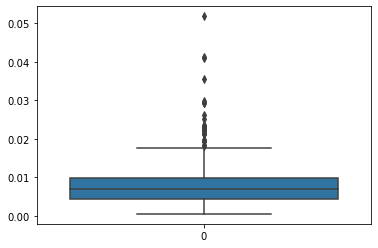

In [21]:
sns.boxplot(data=job_df['%'])

In [22]:
x = job_df['%'].tolist()
y = np.nanpercentile(x,95)
y

0.019519850437743187

In [23]:
job_filter = job_df[job_df['%']>y]

1. As monitoring, we found that the percentage of all job values is quite the same (the mean ~ the median and the std is so small). 
2. However, it still have some outliers. The solution here, we will chose the job values that have % > tp95 and add to the model. 

In [24]:
# Replace value of Job column to 'Other' if is not in >tp95 list: 
df_train['job'] = df_train['job'].apply(lambda x: 'Other' if x not in job_filter['job'].tolist() else x)

##### **Category:**

In [25]:
cat_df = count_percentage(df_train, 'category', 'is_fraud', 'cc_num')
cat_df['%'].describe()

count    14.000000
mean      0.005629
std       0.005531
min       0.001549
25%       0.002192
50%       0.002906
75%       0.006593
max       0.017561
Name: %, dtype: float64

<AxesSubplot:ylabel='%'>

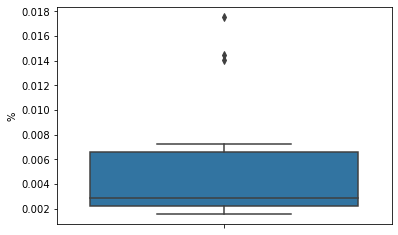

In [26]:
sns.boxplot(data=cat_df, y='%')

In [27]:
df_train['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

##### **Transaction Time:**

In [28]:
df_train['tns_hour'] = df_train['trans_date_trans_time'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S.%f').hour)

In [29]:
time_df = count_percentage(df_train, 'tns_hour', 'is_fraud', 'cc_num')

<AxesSubplot:xlabel='tns_hour', ylabel='%'>

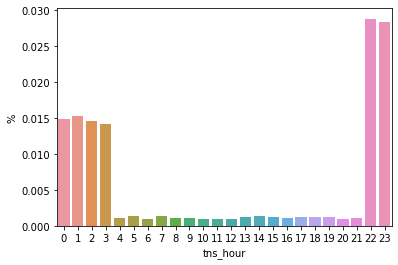

In [30]:
sns.barplot(data=time_df, x='tns_hour', y='%')

As barplot, we found that on 22pm and 23pm, users intend to have fraud more.
==> We can use this feature for the model 

#### **Conclusion**

After EDA we will keep the below columns to the model: 
1. cc_num: the primary key of the dataset 
2. job: the job of the card holder, keep job value that have % > percentile 90.
3. lat,long: the location of card holder but in numeric type (we drop street, city, state, city_pop, zip since they have the same meaning)
4. category: the category of the merchant (we will drop the merchant since the category have less value but the same meaning with merchant)
5. merch_lat/merch_long: the location of merchant 
6. Hour of transacion time
7. amt: the amout of the money 

In [31]:
df_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'tns_hour'],
      dtype='object')

In [32]:
df_train = df_train[['cc_num','category','amt','lat','long','job','merch_lat','merch_long','is_fraud','tns_hour']]

### **Encoding & Normalizing:** 

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1296675 non-null  int64  
 1   category    1296675 non-null  object 
 2   amt         1296675 non-null  float64
 3   lat         1296675 non-null  float64
 4   long        1296675 non-null  float64
 5   job         1296675 non-null  object 
 6   merch_lat   1296675 non-null  float64
 7   merch_long  1296675 non-null  float64
 8   is_fraud    1296675 non-null  int64  
 9   tns_hour    1296675 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 98.9+ MB


In [34]:
list_columns = ['category','job']

df_train = onehot_encoded(df_train, list_columns)

Start onehot process


In [35]:
df_train.columns

Index(['cc_num', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'is_fraud',
       'tns_hour', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'job_Artist',
       'job_Charity officer', 'job_Civil Service administrator',
       'job_Clinical cytogeneticist', 'job_Community development worker',
       'job_Conservator, museum/gallery', 'job_Economist',
       'job_Education officer, community', 'job_Engineer, structural',
       'job_Field trials officer', 'job_Geneticist, molecular',
       'job_Interior and spatial designer', 'job_Lawyer',
       'job_Magazine journalist', 'job_Marketing executive',
       'job_Medical technical officer', 'job_Minerals surveyor', 'job_Other

In [36]:
list_columns = df_train.columns.tolist()
df_train = normalize(df_train, list_columns)

Start normalized columns
Normalize process done in: 1.7259597778320312 s


In [37]:
df_train.head(2)

,cc_num,amt,lat,long,merch_lat,merch_long,is_fraud,tns_hour,category_entertainment,category_food_dining,...,job_Magazine journalist,job_Marketing executive,job_Medical technical officer,job_Minerals surveyor,job_Other,"job_Pharmacist, hospital",job_Purchasing manager,"job_Solicitor, Scotland",job_TEFL teacher,job_Writer
0,5.414540e-04,0.000137,0.343968,0.864638,0.350302,0.848602,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.141762e-07,0.003670,0.618450,0.485682,0.621488,0.486208,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### **Pipeline Function to apply for Test data:** 

In [38]:
def pipeline_func(data): 
    #Process category data:
    data['job'] = data['job'].apply(lambda x: 'Other' if x not in job_filter['job'].tolist() else x)
    data['tns_hour'] = data['trans_date_trans_time'].apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d %H:%M:%S.%f').hour)
    #Feature Selection: 
    data = data[['cc_num','category','amt','lat','long','job','merch_lat','merch_long','is_fraud','tns_hour']]
    #Encoding: 
    list_encode = ['category','job']
    data = onehot_encoded(data, list_encode)
    #Normalize: 
    list_nor = data.columns.tolist()
    data = normalize(data, list_nor)    
    return data    

In [39]:
df_test = pipeline_func(df_test)

Start onehot process
Start normalized columns
Normalize process done in: 0.614483118057251 s


In [40]:
df_train.shape

(1296675, 45)

In [41]:
df_test.shape

(555719, 45)

Test and Train data has the same number of columns ==> Start apply model

### **Apply model** 

In [42]:
x_train = df_train.drop('is_fraud', axis = 1)
y_train = df_train[['is_fraud']]
x_test = df_test.drop('is_fraud', axis = 1)
y_test = df_test[['is_fraud']]

#### **Logistic Regression:**

In [61]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0)
clf.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [62]:
y_pred = clf.predict(x_test)

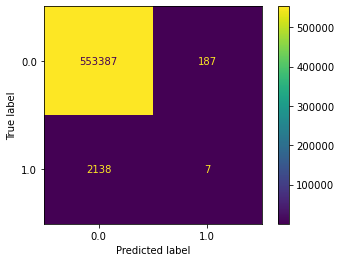

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [64]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
balanced_accuracy

0.5014627991904743

**We use ROC curve to check whether other probability threshold can make higher balanced accuracy**

In [77]:
from sklearn import metrics

#ROC CURVE
# Determine the false positive and true positive rates
y_pred_proba = clf.predict_proba(x_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)

roc_df = pd.DataFrame(zip(fpr, tpr, threshold), columns = ['FPR', 'TPR', 'threshold'])
roc_df

,FPR,TPR,threshold
0,0.000000,0.000000,2.000000
1,0.000002,0.000000,1.000000
2,0.000242,0.000000,0.703645
3,0.000242,0.000466,0.703374
4,0.000246,0.000466,0.693226
...,...,...,...
3430,0.999539,0.999068,0.000146
3431,0.999539,0.999534,0.000146
3432,0.999805,0.999534,0.000141
3433,0.999805,1.000000,0.000141


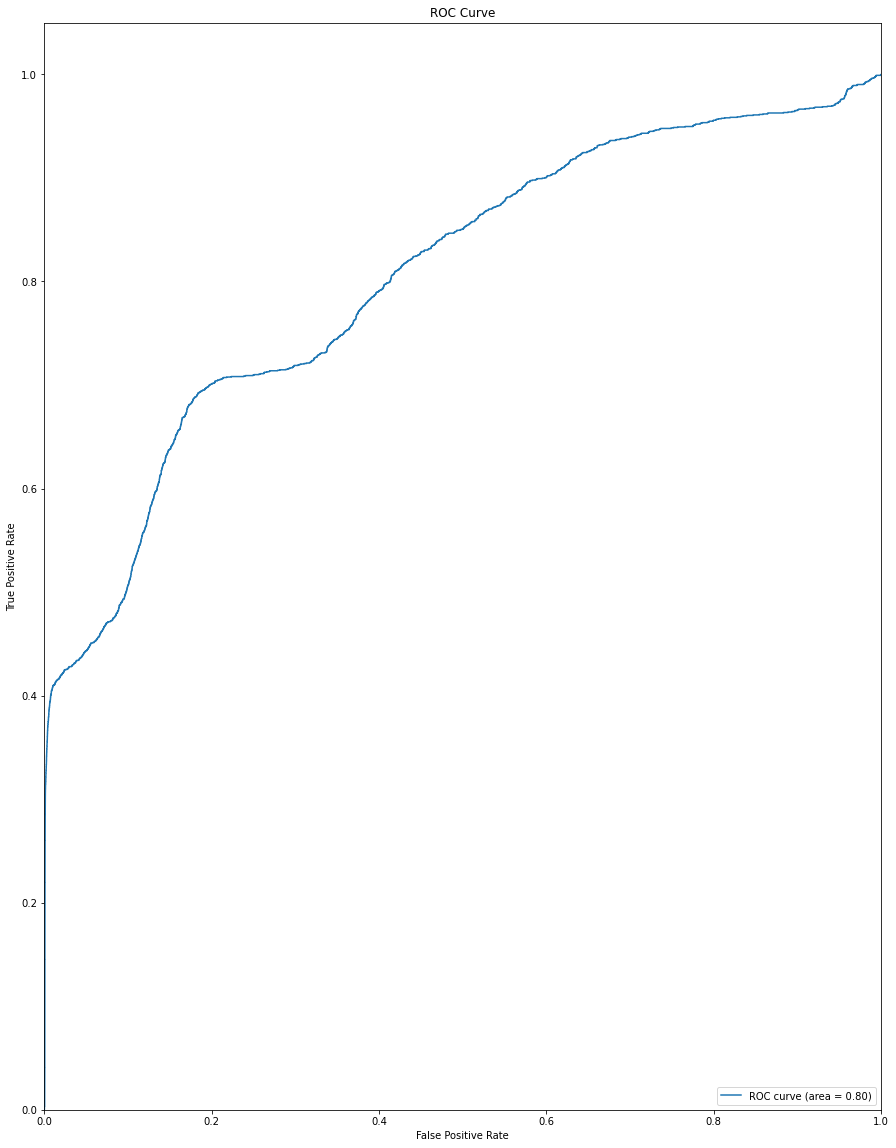

In [86]:
# Plot of a ROC curve for a specific class
plt.figure(figsize = (15,20))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
#plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [117]:
'''
This code is to run all threshold and returns the balance accuracy for each threshold. 
'''

from tqdm.notebook import tqdm

list_acc = []
result = []

pbar = tqdm(total = len(roc_df))
for i in roc_df['threshold']:
    pbar.update(1)
        
    y_pred_new_threshold = (clf.predict_proba(x_test)[:, 1] >= i).astype(int)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_new_threshold)
    list_acc+=[[i,balanced_accuracy]]
pbar.close()

  0%|          | 0/3435 [00:00<?, ?it/s]

In [125]:
test = pd.DataFrame(list_acc, columns = ['threshold','balance_acc'])

In [124]:
test[test['balance_acc']>0.75]

,threshold,balance_acc
1997,0.008933,0.750135
1998,0.008932,0.750131
1999,0.008932,0.750364
2000,0.008931,0.750344
2001,0.008931,0.750577
...,...,...
2153,0.007673,0.751048
2154,0.007621,0.750293
2155,0.007621,0.750527
2156,0.007599,0.750184


We found that the highest balanced accuracy the model can return is 75% with the probability threshold is 0.008 (is quite not make sense for our data) ==> We will do not use Logistic Regression

#### **Decision Tree:**

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(x_train,y_train)

In [ ]:
y_tree_pre_train = clf.predict(x_train)
y_tree_pre_test = clf.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_tree_pre_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_test.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()

In [ ]:
# Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

# Add labels and title
# plt.xlabel('Category')
# plt.ylabel('Value')
plt.title('Feature Important')

# Show plot
plt.show()

The accuracy of Logistic Regression is 77% --> Amt is the high important feature that model considered when calculating

#### **Random Forest:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(x_train, y_train)
y_ranf_pre_train = clf.predict(x_train)

y_ranf_pre_test = clf.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

### Conclusion: 

The balance accuracy: 
* Logistic Regression: 50%
* Decision Tree: 77%
* Random Forest: 77% 
* --> We will choose Decision Tree or Random Forest